# Forecasting Risk of Alcohol Lapse up to Two Weeks in Advance using

Time-lagged Machine Learning Models

Kendra Wyant (Department of Psychology, University of Wisconsin-Madison)  
Gaylen E. Fronk (Department of Psychology, University of Wisconsin-Madison)  
Jiachen Yu (Department of Psychology, University of Wisconsin-Madison)  
John J. Curtin (Department of Psychology, University of Wisconsin-Madison)  
June 7, 2025

We evaluated machine learning models predicting future alcohol lapses within 24-hour prediction windows that were systematically lagged further into the future (1 day, 3 days, 1 week, and 2 weeks). We engineered features from 4x daily ecological momentary assessment. Participants (N=151; 51% male; mean age=41; 87% White, 97% Non-Hispanic) in early recovery from alcohol use disorder provided data for up to three months. We used nested cross-validation to select and evaluate models. Median posterior probabilities for auROCs were high (0.85–0.91). Still, performance declined with increasing lags (probabilities = 1). However, the difference in median posterior probabilities may not be clinically meaningful. Models also performed worse for non-advantaged groups (not White vs. non-Hispanic White, below poverty vs. above poverty, female vs. male; probabilities \> .81). This study demonstrates the feasibility of predicting next-day alcohol lapses up to two weeks into the future. This advanced notice offers time to implement support options not immediately available. However, fairness concerns remain and are discussed further in the paper.

In [ ]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(source("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true"))

path_models_lag <- format_path(str_c("studydata/risk/models/lag"))
path_processed <- format_path("studydata/risk/data_processed/lag")

options(knitr.kable.NA = '')

In [ ]:
# read in tibbles for in-line code

test_metrics_all_pp_perf <- read_csv(here::here(path_models_lag, 
                                                "pp_perf_tibble.csv"), 
                                     col_types = cols())

ci_baseline <- read_csv(here::here(path_models_lag, "contrast_baseline.csv"), 
                        col_types = cols())

ci_lag <- read_csv(here::here(path_models_lag, "contrast_adjacent.csv"), 
                   col_types = cols())

pp_dem <- read_csv(here::here(path_models_lag, "pp_dem_all.csv"), col_types = cols())

pp_dem_contrast <- read_csv(here::here(path_models_lag, "pp_dem_contrast_all.csv"), col_types = cols())

screen <- read_csv(here::here(path_processed, "dem_tibble.csv"),
                   col_types = cols())

lapses_per_subid <- read_csv(here::here(path_processed, "lapse_tibble.csv"),
                             col_types = cols())

# Introduction

Alcohol and other substance use disorders (SUDs) are serious chronic conditions, characterized by high relapse rates\[@mclellanDrugDependenceChronic2000; @dennisManagingAddictionChronic2007\], substantial co-morbidity with other physical and mental health problems\[@substanceabuseandmentalhealthservicesadministration2023NSDUHDetailed; @dennisManagingAddictionChronic2007\], and an increased risk of mortality \[@hedegaardDrugOverdoseDeaths; @centersfordiseasecontrolandpreventioncdcAnnualAverageUnited\]. Too few individuals receive medications or clinician-delivered interventions to help them initially achieve abstinence and/or reduce harms associated with their use \[@substanceabuseandmentalhealthservicesadministration2023NSDUHDetailed\]. Yet, this problem is even worse for subsequent continuing care during SUD recovery. Continuing care, including both risk monitoring and ongoing support, is the gold standard for managing chronic health conditions such as diabetes, asthma, and HIV. Yet, continuing care for SUDs is largely lacking despite ample evidence that SUDs are chronic, relapsing conditions \[@substanceabuseandmentalhealthservicesadministration2023NSDUHDetailed; @stanojlovicTargetingBarriersSubstance2021; @sociasAdoptingCascadeCare2016\].

When available, an important focus of continuing care during SUD recovery is the prevention of lapses (i.e., single instances of goal-inconsistent substance use) and full relapse back to harmful use \[@marlattRelapsePreventionMaintenance1985; @witkiewitzRelapsePreventionAlcohol2004\]. Critically, the risk factors that instigate lapses during recovery are individualized, numerous, dynamic, interactive, and non-linear \[@witkiewitzModelingComplexityPosttreatment2007; @brandonRelapseRelapsePrevention2007\]. Therefore, the optimal supports to address these risk factors and encourage continued, successful recovery vary both across individuals and within an individual over time. Given this, continuing care could benefit greatly from a precision mental health approach that seeks to provide the right support to the right individual at the right time, every time \[@bickmanAchievingPrecisionMental2016; @derubeisHistoryCurrentStatus2019; @kranzlerPersonalizedTreatmentAlcohol2012\]. However, such monitoring and personalized support must also be highly scalable to address the substantial unmet need for SUD continuing care.

Recent advances in both smartphone sensing \[@mohrPersonalSensingUnderstanding2017\] and machine learning \[@hastieElementsStatisticalLearning2009\] hold promise as a scalable foundation for monitoring and personalized support during SUD recovery. Smartphone sensing approaches (e.g., ecological momentary assessment, geolocation sensing) can provide the frequent, longitudinal measurement of proximal risk factors that is necessary for prediction of future lapses with high temporal precision. Ecological momentary assessment (EMA) may be particularly well-suited for lapse prediction because it can provide privileged access to the subjective experiences (e.g., craving, affect, stress, motivation, self-efficacy) that are targets for change in evidence based approaches for relapse prevention \[@marlattRelapsePreventionMaintenance1985; @witkiewitzRelapsePreventionAlcohol2004; @bowenMindfulnessBasedRelapsePrevention2021\]. Furthermore, individuals with SUDs have found EMA to be acceptable for sustained measurement for up to a year with relatively high compliance \[@wyantAcceptabilityPersonalSensing2023; @moshontzProspectivePredictionLapses2021\], suggesting that this method is feasible for long-term monitoring throughout SUD recovery.

Machine learning models are well-positioned to use EMAs as inputs to provide temporally precise prediction of the probability of future lapses with sufficiently high performance to support decisions about interventions and other supports for specific individuals. These models can handle the high dimensional feature sets that may result from feature engineering densely sampled raw EMA over time \[@wyantMachineLearningModels2023\]. They can also accommodate non-linear and interactive relationships between features and lapse probability that are likely necessary for accurate prediction of lapse probability. And rapid advances in the tools for interpretable machine learning (e.g, Shapley values \[@lundbergUnifiedApproachInterpreting2017\]) now allow us to probe these models to understand which risk features contribute most strongly to a lapse prediction for a specific individual at a specific moment in time. Interventions, supports, and/or lifestyle adjustments can then be personalized to address these risks following from our understanding about relapse prevention.

Preliminary research is now emerging that uses features derived from EMAs in machine learning models to predict the probability of future alcohol use \[@baeMobilePhoneSensors2018; @soysterPooledPersonspecificMachine2022; @waltersUsingMachineLearning2021; @wyantMachineLearningModels2023\]. This research is important because it rigorously required strict temporal ordering necessary for true prediction, with features measured before alcohol use outcomes. It also used resampling methods (e.g., cross-validation) that prioritize model generalizability to increase the likelihood these models will perform well with new people. And perhaps most importantly, @wyantMachineLearningModels2023 demonstrated that machine learning models using EMA can provide predictions with very high temporal precision at clinically implementable levels of performance. Specifically, they developed models that predict lapses in the immediate future (i.e., the next day and even the next hour) with area under the receiver operating characteristic curve of 0.91 and 0.93, respectively.

@wyantMachineLearningModels2023’s next day lapse prediction model can provide personalized support recommendations to address immediate risks for possible lapses in that next day. Features derived from past EMAs can be updated in the early morning to yield the predicted lapse probability for an individual that day. Personalized supports that target the top features contributing to that prediction can be provided to assist them that day. For example, if predicted lapse probability is high due to recent frequent craving, they could be reminded about the benefits of urge surfing or distracting activities during brief periods when cravings arise. Conversely, guided relaxation techniques could be recommended if lapse probability was high due to recent past and anticipated stressors that day. Patients could also be assisted to implement any of these recommendations by videos or other tools within a digital therapeutic. Curtin and colleagues are currently evaluating outcomes associated with the use of this “smart” (machine learning guided) monitoring and personalized support system for patients in recovery from alcohol use disorder \[@wyantOptimizingMessageComponentsinprep\].

Despite the promise offered by a monitoring and personalized support system based on immediate future risks (e.g., the next day), such a system has limitations. Most importantly, recommendations must be limited to previously learned skills and/or supports that are available to implement that day. However, many risks may require supports that are not available in the moment. For example, to address lifestyle imbalances, several future positive activities may need to be planned. Time with supportive friends or an AA sponsor to help with many risks may require time to schedule. Similarly, work or family schedules may need to be adjusted to return to attending self-help meetings. If new recovery skills or therapeutic activities are needed to address emerging risks, sessions with a therapist may need to be booked to assist the patient to acquire these new skills. In all of these instances, patients would benefit from advanced warning about changes in their lapse probability and the associated risks that contribute to these changes. A smart monitoring and personalized support system could provide this advanced warning by lagging lapse probability predictions further into the future (e.g., predicting lapse probability in a 24-hour window that begins two weeks in the future). However, we do not know if such lagged models could maintain adequate performance for clinical use with individuals.

In this study, we evaluated the performance of machine learning models that predict the probability of future lapses within 24-hour prediction windows that were systematically lagged further into the future. We considered several meaningful lags for these prediction windows: 1 day, 3 days, 1 week, and 2 weeks. We conducted pre-registered analyses of both the absolute performance of these lagged models and their relative performance compared to a baseline model that predicted lapse probability in the immediate next day (i.e., no lag). In addition to the aggregate performance of these models, we also evaluated algorithmic fairness by comparing model performance across important subgroups that have documented disparities in treatment access and/or outcomes. These include comparisons by race/ethnicity \[@pinedoCurrentReexaminationRacial2019; @kilaruIncidenceTreatmentOpioid2020\], income \[@olfsonHealthcareCoverageService2022\], and sex at birth \[@greenfieldSubstanceAbuseTreatment2007; @kilaruIncidenceTreatmentOpioid2020\]. Finally, we calculated Shapley values for feature categories defined by EMA items to better understand how these models make their prediction and how these features can be used to recommend personalized supports.

# Methods

## Transparency and Openness

We adhere to research transparency principles that are crucial for robust and replicable science. We preregistered our data analytic strategy. We reported how we determined the sample size, all data exclusions, all manipulations, and all study measures. We provide a transparency report in the supplement. Finally, our data, questionnaires and other study materials are publicly available on our OSF page (<https://osf.io/xta67/>), and our annotated analysis scripts and results are publicly available on our study website (<https://jjcurtin.github.io/study_lag/>).

## Participants

We recruited participants in early recovery (1-8 weeks of abstinence) from moderate to severe alcohol use disorder in Madison, Wisconsin, US for a three month longitudinal study. Participants were recruited through print and targeted digital advertisements and partnerships with treatment centers. We required that participants:

1.  were age 18 or older,
2.  could write and read in English,
3.  had at least moderately severe alcohol use disorder (\>= 4 self-reported DSM-5 symptoms),
4.  were abstinent from alcohol for 1-8 weeks, and
5.  were willing to use a single smartphone (personal or study provided) while on study.

We also excluded participants exhibiting severe symptoms of psychosis or paranoia.[1]

One hundred ninety-two participants were eligible. Of these, 191 consented to participate in the study at the screening visit, and 169 subsequently enrolled in the study at the enrollment visit, which occurred approximately one week later. Fifteen participants discontinued before the first monthly follow-up visit. We excluded data from one participant who did not maintain a goal of abstinence during their participation. We also excluded data from two participants due to evidence of careless responding and unusually low compliance. Our final sample consisted of 151 participants. This sample size was determined based on traditional power analysis methods for logistic regression \[@hsiehSampleSizeTables1989\] because comparable approaches for machine learning models have not yet been validated.

## Procedure

Participants completed five study visits over approximately three months. After an initial phone screen, participants attended an in-person screening visit to determine eligibility, complete informed consent, and collect self-report measures. Eligible, consented participants returned approximately one week later for an intake visit. Three additional follow-up visits occurred about every 30 days that participants remained on study. Participants were expected to complete four daily EMAs while on study. Other personal sensing data streams (geolocation, cellular communications, sleep quality, and audio check-ins) were collected as part of the parent grant’s aims (R01 AA024391). Participants could earn up to \$150/month if they completed all study visits, had 10% or less missing EMA data and opted in to provide data for other personal sensing data streams.

## Measures

### Ecological Momentary Assessments

Participants completed four brief (7-10 questions) EMAs daily. The first and last EMAs of the day were scheduled within one hour of participants’ typical wake and sleep times. The other two EMAs were scheduled randomly within the first and second halves of their typical day, with at least one hour between EMAs. Participants learned how to complete the EMA and the meaning of each question during their intake visit.

On all EMAs, participants reported dates/times of any previously unreported past alcohol use. Next, participants rated the maximum intensity of recent (i.e., since last EMA) experiences of craving, risky situations, stressful events, and pleasant events. Finally, participants rated their current affect on two bipolar scales: valence (Unpleasant/Unhappy to Pleasant/Happy) and arousal (Calm/Sleepy to Aroused/Alert).

On the first EMA each day, participants also rated the likelihood of encountering risky situations and stressful events in the next week and the likelihood that they would drink alcohol in the next week (i.e., abstinence self-efficacy).

### Individual Characteristics

We collected self-report information about demographics (age, sex at birth, race, ethnicity, education, marital status, employment, and income) and clinical characteristics (AUD milestones, number of quit attempts, lifetime AUD treatment history, lifetime receipt of AUD medication, DSM-5 AUD symptom count, current drug use \[@whoassistworkinggroupAlcoholSmokingSubstance2002\], and presence of psychological symptoms \[@derogatislBriefSymptomInventory\]) to characterize our sample. DSM-5 AUD symptom count and presence of psychological symptoms were also used to determine eligibility. Demographic information was included as features in our models. A subset of these variables (sex at birth, race, ethnicity, and income) were used for model fairness analyses, as they have documented disparities in treatment access and outcomes.

As part of the aims of the parent project we collected many other trait and state measures throughout the study. A complete list of all measures can be found on our study’s OSF page.

## Data Analytic Strategy

Data preprocessing, modeling, and Bayesian analyses were done in R using the tidymodels ecosystem \[@kuhnTidymodelsCollectionPackages2020; @kuhnTidyposteriorBayesianAnalysis2022; @goodrichRstanarmBayesianApplied2023\]. Models were trained and evaluated using high-throughput computing resources provided by the University of Wisconsin Center for High Throughput Computing \[@chtc\].

### Predictions

A *prediction timepoint* (@fig-method, Panel A) is the hour at which our model calculates a predicted probability of a lapse within a future 24-hour prediction window for any specific individual. We calculated the features used to make predictions at each prediction timepoint within a feature scoring epoch that included all available EMAs up until, but not including, the prediction timepoint. The first prediction timepoint for each participant was 24 hours from midnight on their study start date. This ensured at least 24 hours of past EMAs were available in the feature scoring epoch. Subsequent prediction timepoints for each participant repeatedly rolled forward hour-by-hour until the end of their study participation.

The *prediction window* (@fig-method, Panel B) spans a period of time in which a lapse might occur. The prediction window width for all models was 24 hours (i.e., models predicted the probability of a lapse occurring within a specific 24-hour period). Prediction windows rolled forward hour-by-hour with the prediction timepoint. However, there were five possible *lag times* between the prediction timepoint and start of the associated prediction window. A prediction window either started immediately after the prediction time point (no lag) or was lagged by 1 day, 3 days, 1 week, or 2 weeks into the future.

Given this structure, our models provided hour-by-hour predicted probabilities of an alcohol lapse in a future 24 hour period. Depending on the model, that future period (the prediction window) might start immediately after the prediction timepoint or up to 2 weeks into the future. For example, at midnight on the 30th day of participation, the feature scoring epoch would include the past 30 days of EMAs. Separate models would predict the probability of lapse for 24 hour periods staring at midnight that day, or similar 24 hour periods starting 1 day, 3 days, 1 week or 2 weeks after midnight on day 30.

``` python
knitr::include_graphics(path = here::here("figures/methods.png"), error = FALSE)
```

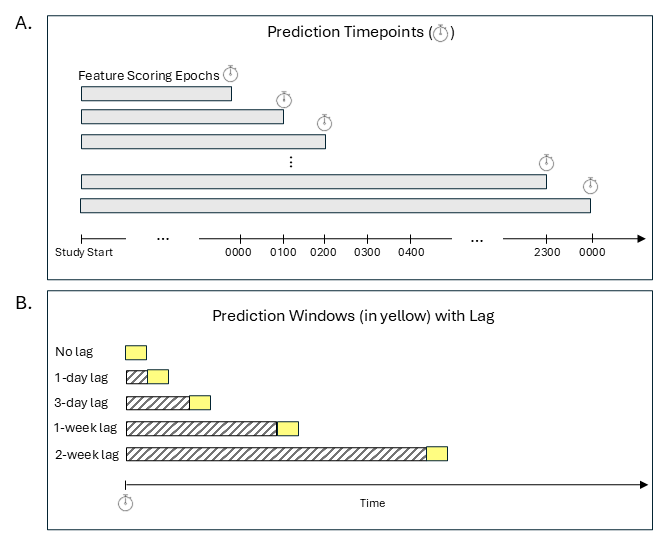

### Labels

The start and end date/time of past drinking episodes were reported on the first EMA item. A prediction window was labeled *lapse* if the start date/hour of any drinking episode fell within that window. A window was labeled *no lapse* if no alcohol use occurred within that window +/- 24 hours. If no alcohol use occurred within the window but did occur within 24 hours of the start or end of the window, the window was excluded. [2]

We ended up with a total of 274,179 labels for our baseline (no lag) model, 270,911 labels for our 1-day lagged model, 264,362 labels for our 3-day lagged model, 251,458 labels for our 1-week lagged model, and 228,420 labels for our 2-week lagged model.

### Feature Engineering

Features were calculated using only data collected in feature scoring epochs before each prediction timepoint to ensure our models were making true future predictions. For our no lag models the prediction timepoint was at the start of prediction window, so all data prior to the start of the prediction window was included. For our lagged models, the prediction timepoint was 1 day, 3 days, 1 week, or 2 weeks prior to the start of the prediction window, so the last EMA data used for feature engineering were collected 1 day, 3 days, 1 week, or 2 weeks prior to the start of the prediction window.

A total of 285 features were derived from three data sources:

1.  *Prediction window*: We dummy-coded features for day of the week for the start of the prediction window.

2.  *Demographics*: We created quantitative features for age (in years) and personal income (in dollars), and dummy-coded features for sex at birth (male vs. female), race/ethnicity (non-Hispanic White vs. not White), marital status (married vs. not married vs. other), education (high school or less vs. some college vs. college degree), and employment (employed vs. unemployed).

3.  *Previous EMA responses*: We created raw and change features using EMAs in varying feature scoring epochs (i.e., 12, 24, 48, 72, and 168 hours) before the prediction timepoint for all EMA items. Raw features included min, max, and median scores for each EMA item across all EMAs in each epoch for that participant. We calculated change features by subtracting each participant’s baseline mean score for each EMA item from their raw feature. These baseline mean scores were calculated using all of their EMAs collected from the start of their participation until the prediction timepoint. We also created raw and change features based on the most recent response for each EMA question and raw and change rate features from previously reported lapses and number of completed EMAs.

Other generic feature engineering steps included imputing missing data (median imputation for numeric features, mode imputation for nominal features) and removing zero and near-zero variance features as determined from held-in data (see Cross-validation section below).

### Model Training and Evaluation

#### Model Configurations

We trained and evaluated five separate classification models: one baseline (no lag) model and one model for 1 day, 3 day, 1 week, and 2 week lagged predictions. We considered four well-established statistical algorithms (elastic net, XGBoost, regularized discriminant analysis, and single layer neural networks) that vary across characteristics expected to affect model performance (e.g., flexibility, complexity, handling higher-order interactions natively) \[@kuhnAppliedPredictiveModeling2018\].

Candidate model configurations differed across sensible values for key hyperparameters. They also differed on outcome resampling method (i.e., no resampling and up-sampling and down-sampling of the outcome using majority/no lapse to minority/lapse ratios ranging from 1:1 to 5:1).

#### Cross-validation

We used participant-grouped, nested cross-validation for model training, selection, and evaluation with auROC. auROC indexes the probability that the model will predict a higher score for a randomly selected positive case (lapse) relative to a randomly selected negative case (no lapse). Grouped cross-validation assigns all data from a participant as either held-in or held-out to avoid bias introduced when predicting a participant’s data from their own data. Folds were stratified on a between-subject variable of low vs. high lapsers (low lapsers reported fewer than 10 lapses while on study and hig lapsers reported 10 or more lapses while on study). We used 2 repeats of 5-fold cross-validation for the inner loops (i.e., *validation* sets) and 6 repeats of 5-fold cross-validation for the outer loop (i.e., *test* sets). Best model configurations were selected using median auROC across the 10 validation sets. Final performance evaluation of those best model configurations used median auROC across the 30 test sets.

#### Bayesian Model

We used a Bayesian hierarchical generalized linear model to estimate the posterior probability distributions and 95% Bayesian credible intervals (CIs) from the 30 held-out test sets for our five best models. Following recommendations from the rstanarm team and others \[@rstudioteamRStudioIntegratedDevelopment2020; @gabryPriorDistributionsRstanarm2023\], we used the rstanarm default autoscaled, weakly informative, data-dependent priors that take into account the order of magnitude of the variables to provide some regularization to stabilize computation and avoid over-fitting.[3] We set two random intercepts to account for our resampling method: one for the repeat, and another for the fold nested within repeat. We specified two sets of pre-registered contrasts for model comparisons. The first set compared each lagged model to the baseline no lag model (no lag vs. 1-day lag, no lag vs. 3-day lag, no lag vs. 1-week lag, no lag vs. 2-week lag). The second set compared adjacently lagged models (1-day lag vs. 3-day lag, 3-day lag vs. 1-week lag, 1-week lag vs. 2-week lag). auROCs were transformed using the logit function and regressed as a function of model contrast.

From the Bayesian model we obtained the posterior distribution (transformed back from logit) and Bayeisan CIs for auROCs all five models. To evaluate our models’ overall performance we report the median posterior probability for auROC and Bayesian CIs. This represents our best estimate for the magnitude of the auROC parameter for each model. If the credible intervals do not contain .5 (chance performance), this provides strong evidence (\> .95 probability) that our model is capturing signal in the data.

We then conducted Bayesian model comparisons using our two sets of contrasts - baseline and adjacent lags. For both model comparisons, we determined the probability that the models’ performances differed systematically from each other. We also report the precise posterior probability for the difference in auROCs and the 95% Bayesian CIs.

#### Fairness Analyses

We calculated the median posterior probability and 95% Bayesian CI for auROC for each model separately by race/ethnicity (not White vs. non-Hispanic White), income (below poverty vs. above poverty[4]), and sex at birth (female vs. male). We conducted Bayesian group comparisons to assess the likelihood that each model performs differently by group. We summarize the differences in posterior probabilities for auROC across models. Individual Bayesian fairness contrasts for all five models are available in the supplement.

#### Feature Importance

We calculated Shapley values in log-odds units for binary classification models from the 30 test sets to provide a description of the importance of categories of features across our five models \[@lundbergUnifiedApproachInterpreting2017\]. We averaged the three Shapley values for each observation for each feature (i.e., across the three repeats) to increase their stability. An inherent property of Shapley values is their additivity, allowing us to combine features into feature categories. We created separate feature categories for each of the nine EMA questions, and the rate of past alcohol use. We calculated the local (i.e., for each observation) importance for each category of features by adding Shapley values across all features in a category, separately for each observation. We calculated global importance for each feature category by averaging the absolute value of the Shapley values of all features in the category across all observations. These local and global importance scores based on Shapley values allow us to contextualize relative feature importance for each model.

# Results

## Demographic and Lapse Characteristics

\[@tbl-demohtml\] provides a detailed breakdown of the demographic and clinical characteristics of our sample (N = 151).

``` python
footnote_table_dem_a <- "N = 151"
footnote_table_dem_b <- "*Two participants reported 100 or more quit attempts. We removed these outliers prior to calculating the mean (M), standard deviation (SD), and range."


table_dem |> 
  knitr::kable() |> 
  kable_classic() |> 
  kableExtra::group_rows(start_row = 3, end_row = 4) |> 
  kableExtra::group_rows(start_row = 6, end_row = 10) |> 
  kableExtra::group_rows(start_row = 12, end_row = 13) |> 
  kableExtra::group_rows(start_row = 15, end_row = 20) |> 
  kableExtra::group_rows(start_row = 22, end_row = 30) |> 
  kableExtra::group_rows(start_row = 33, end_row = 37) |> 
  kableExtra::group_rows("Alcohol Use Disorder Milestones", 
                         start_row = 39, end_row = 42, bold = FALSE) |> 
  kableExtra::group_rows("Lifetime History of Treatment (Can choose more than 1)", 
                         start_row = 44, end_row = 50, bold = FALSE) |> 
  kableExtra::group_rows("Received Medication for Alcohol Use Disorder", 
                         start_row = 51, end_row = 52, bold = FALSE) |> 
  kableExtra::group_rows("Current (Past 3 Month) Drug Use", 
                         start_row = 53, end_row = 60, bold = FALSE) |> 
  kableExtra::group_rows(start_row = 62, end_row = 63) |> 
  kableExtra::footnote(general = c(footnote_table_dem_a, footnote_table_dem_b), escape=FALSE)
```

                                                                                                                                                                 N     \% M          SD         Range
  ---------------------------------------------------------------------------------------------------------------------------------------------------------- ----- ------ ---------- ---------- -------------
  Age                                                                                                                                                                     41         11.9       21-72
  Sex                                                                                                                                                                                           
                                                                                                                                                                                                
  Female                                                                                                                                                        74   49.0                       
  Male                                                                                                                                                          77   51.0                       
  Race                                                                                                                                                                                          
                                                                                                                                                                                                
  American Indian/Alaska Native                                                                                                                                  3    2.0                       
  Asian                                                                                                                                                          2    1.3                       
  Black/African American                                                                                                                                         8    5.3                       
  White/Caucasian                                                                                                                                              131   86.8                       
  Other/Multiracial                                                                                                                                              7    4.6                       
  Hispanic, Latino, or Spanish origin                                                                                                                                                           
                                                                                                                                                                                                
  Yes                                                                                                                                                            4    2.6                       
  No                                                                                                                                                           147   97.4                       
  Education                                                                                                                                                                                     
                                                                                                                                                                                                
  Less than high school or GED degree                                                                                                                            1    0.7                       
  High school or GED                                                                                                                                            14    9.3                       
  Some college                                                                                                                                                  41   27.2                       
  2-Year degree                                                                                                                                                 14    9.3                       
  College degree                                                                                                                                                58   38.4                       
  Advanced degree                                                                                                                                               23   15.2                       
  Employment                                                                                                                                                                                    
                                                                                                                                                                                                
  Employed full-time                                                                                                                                            72   47.7                       
  Employed part-time                                                                                                                                            26   17.2                       
  Full-time student                                                                                                                                              7    4.6                       
  Homemaker                                                                                                                                                      1    0.7                       
  Disabled                                                                                                                                                       7    4.6                       
  Retired                                                                                                                                                        8    5.3                       
  Unemployed                                                                                                                                                    18   11.9                       
  Temporarily laid off, sick leave, or maternity leave                                                                                                           3    2.0                       
  Other, not otherwise specified                                                                                                                                 9    6.0                       
  Personal Income                                                                                                                                                         \$34,298   \$31,807   \$0-200,000
  Marital Status                                                                                                                                                                                
                                                                                                                                                                                                
  Never married                                                                                                                                                 67   44.4                       
  Married                                                                                                                                                       32   21.2                       
  Divorced                                                                                                                                                      45   29.8                       
  Separated                                                                                                                                                      5    3.3                       
  Widowed                                                                                                                                                        2    1.3                       
  DSM-5 Alcohol Use Disorder Symptom Count                                                                                                                                8.9        1.9        4-11
  Alcohol Use Disorder Milestones                                                                                                                                                               
  Age of first drink                                                                                                                                                      14.6       2.9        6-24
  Age of regular drinking                                                                                                                                                 19.5       6.6        11-56
  Age at which drinking became problematic                                                                                                                                27.8       9.6        15-60
  Age of first quit attempt                                                                                                                                               31.5       10.4       15-65
  Number of Quit Attempts\*                                                                                                                                               5.5        5.8        0-30
  Lifetime History of Treatment (Can choose more than 1)                                                                                                                                        
  Long-term residential (6+ months)                                                                                                                              8    5.3                       
  Short-term residential (\< 6 months)                                                                                                                          49   32.5                       
  Outpatient                                                                                                                                                    74   49.0                       
  Individual counseling                                                                                                                                         97   64.2                       
  Group counseling                                                                                                                                              62   41.1                       
  Alcoholics Anonymous/Narcotics Anonymous                                                                                                                      93   61.6                       
  Other                                                                                                                                                         40   26.5                       
  Received Medication for Alcohol Use Disorder                                                                                                                                                  
  Yes                                                                                                                                                           59   39.1                       
  No                                                                                                                                                            92   60.9                       
  Current (Past 3 Month) Drug Use                                                                                                                                                               
  Tobacco products (cigarettes, chewing tobacco, cigars, etc.)                                                                                                  84   55.6                       
  Cannabis (marijuana, pot, grass, hash, etc.)                                                                                                                  66   43.7                       
  Cocaine (coke, crack, etc.)                                                                                                                                   18   11.9                       
  Amphetamine type stimulants (speed, diet pills, ecstasy, etc.)                                                                                                15    9.9                       
  Inhalants (nitrous, glue, petrol, paint thinner, etc.)                                                                                                         3    2.0                       
  Sedatives or sleeping pills (Valium, Serepax, Rohypnol, etc.)                                                                                                 22   14.6                       
  Hallucinogens (LSD, acid, mushrooms, PCP, Special K, etc.)                                                                                                    14    9.3                       
  Opioids (heroin, morphine, methadone, codeine, etc.)                                                                                                          16   10.6                       
  Reported 1 or More Lapse During Study Period                                                                                                                                                  
                                                                                                                                                                                                
  Yes                                                                                                                                                           84   55.6                       
  No                                                                                                                                                            67   44.4                       
  Number of reported lapses                                                                                                                                               6.8        12         0-75
  [Note: ]{style="font-style: italic;"}                                                                                                                                                         
  N = 151                                                                                                                                                                                       
  \*Two participants reported 100 or more quit attempts. We removed these outliers prior to calculating the mean (M), standard deviation (SD), and range.                                       

## Model Evaluation

@fig-pp presents the full posterior probability distributions for auROC for each model (no lag, 1-day, 3-day, 1-week, and 2-week lag). The median auROCs from these posterior distributions were 0.91 (no lag), 0.89 (1-day lag), 0.88 (3-day lag), 0.87 (1-week lag), and 0.85 (2-week lag). These values represent our best estimates for the magnitude of the auROC parameter for each model. The 95% Bayesian CI for the auROCs for these models were relatively narrow and did not contain 0.5: no lag \[0.90-0.92\], 1-day lag \[0.88-0.90\], 3-day lag \[0.87-0.90\], 1-week lag \[0.85-0.89\], 2-week lag \[0.83-0.87\].

[1] Defined as scores \>2.2 or 2.8, respectively, on the psychosis or paranoia scales of the Symptom Checklist–90 \[@derogatislBriefSymptomInventory\]

[2] We used this conservative 24-hour fence for labeling windows as no lapse (vs. excluded) to increase the fidelity of these labels. Given that most windows were labeled no lapse, and the outcome was highly unbalanced, it was not problematic to exclude some no lapse events to further increase confidence in those labels.

[3] Priors were set as follows: residual standard deviation ~ normal(location=0, scale=exp(2)), intercept (after centering predictors) ~ normal(location=2.3, scale=1.3), the two coefficients for window width contrasts ~ normal (location=0, scale=2.69), and covariance ~ decov(regularization=1, concentration=1, shape=1, scale=1).

[4] The poverty cutoff was defined from the 2024 federal poverty line for the 48 contiguous United States. Participants at or below \$15,060 annual income were categorized as below poverty.

``` python
pp_tidy |> 
  mutate(model = factor(model, levels = c("lag0", "lag24", "lag72", "lag168", "lag336"),
                        labels = c("No lag", "1 day", "3 days", "1 week", "2 weeks"))) |>
  ggplot() + 
  geom_histogram(aes(x = posterior), fill = "light grey", color = "black", linewidth = .5,  
                 bins = 60) +
  geom_segment(mapping = aes(y = 3400, yend = 3800, x = pp_median, xend = pp_median),
               linewidth = .5, data = ci) +
  geom_segment(mapping = aes(y = 3600, yend = 3600, x = pp_lower, xend = pp_upper),
                linewidth = .5, data = ci) +
  facet_wrap(~model, ncol = 1) +
  geom_vline(xintercept = .5, linewidth = .5, linetype = "dashed") +
  scale_y_continuous("Posterior Probability") +
  xlab("Area Under ROC Curve") +
  expand_limits(x = c(.5, 1)) +
  theme_classic() 
```

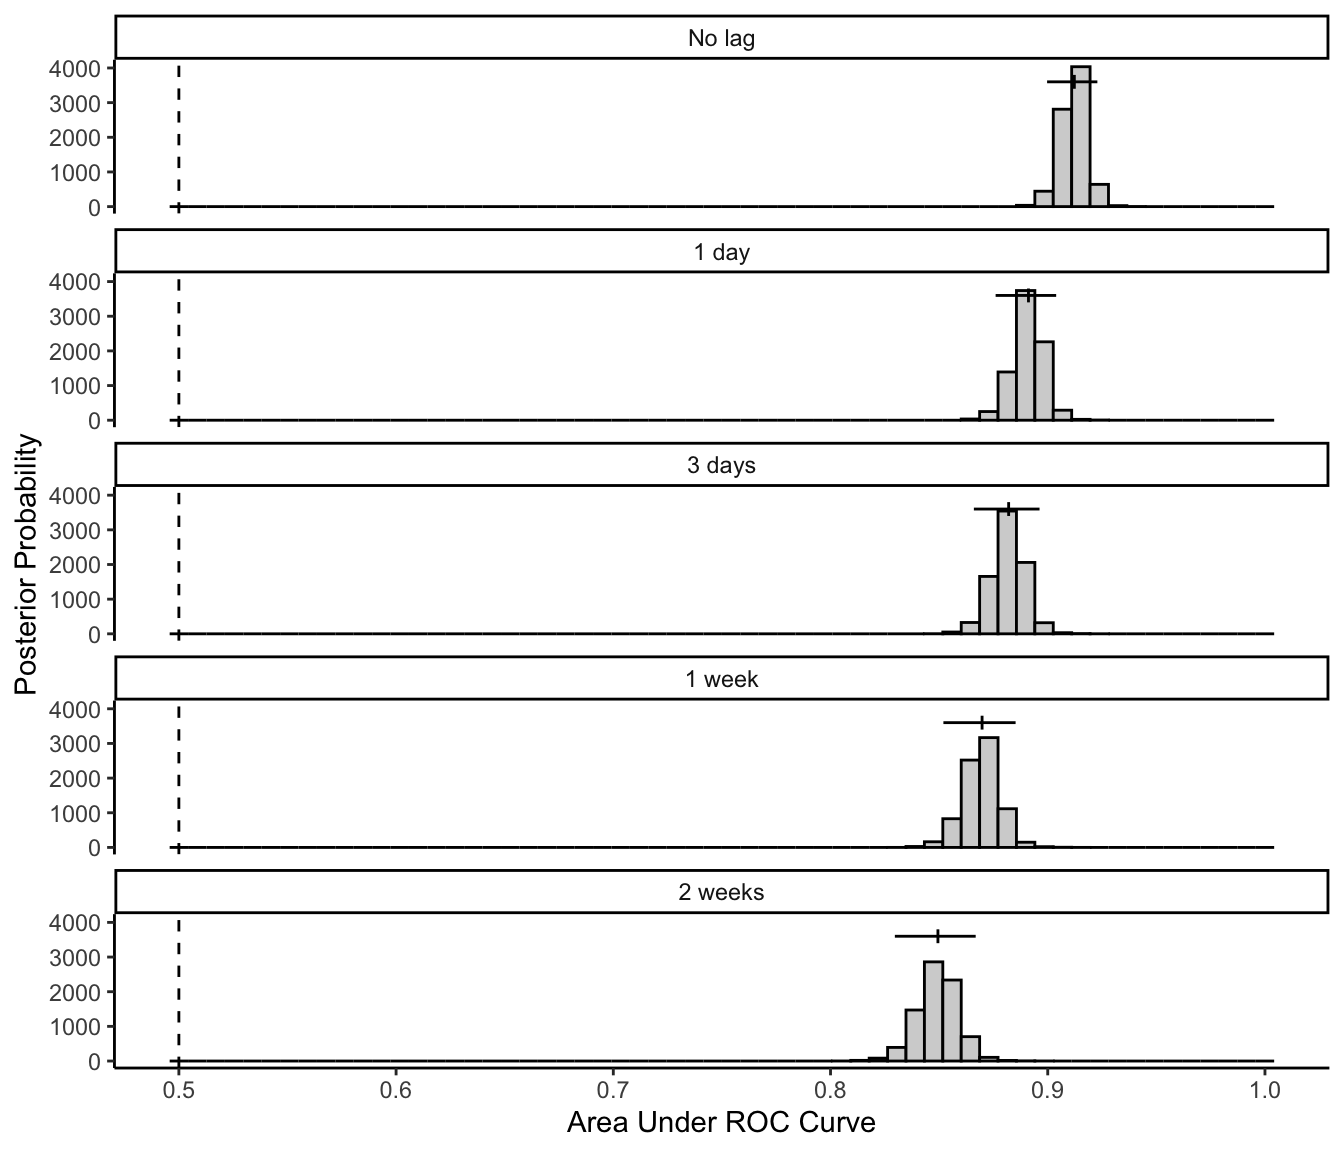

## Model Comparisons

@tbl-model presents the median difference in auROC, 95% Bayesian CI, and posterior probability that that the auROC difference was greater than 0 for all baseline and adjacent lag contrasts. Median auROC differences greater than 0 indicate the more immediate model, on average, out-performed the more lagged model (e.g., no lag - 1-day lag, 1-day lag - 3-day lag). There was strong evidence (probabilities = 1) that the lagged models performed worse than the baseline (no lag) model, with average drops in auROC ranging from 0.02-0.06, and the previous adjacent lagged model, with average drops in auROC ranging from 0.01-0.02.

``` python
footnote_table_model <- "Median auROC differences greater than 0 indicate the more immediate model, on average, out-performed the more lagged model (e.g., no lag - 1-day lag, 1-day lag - 3-day lag). Bayesian CI represents the range of values where there is a 95% probability that the true auROC difference lies within that range. Probability indicates the posterior probability that this difference is greater than 0 (i.e., the models are performing differently)."

table_ci |> 
  knitr::kable() |> 
  kable_classic() |> 
  kableExtra::column_spec(1, width = "25em") |> 
  kableExtra::group_rows(start_row = 2, end_row = 5) |> 
  kableExtra::group_rows(start_row = 7, end_row = 9) |> 
  kableExtra::row_spec(5, extra_css = "border-bottom: 1px solid") |> 
  kableExtra::add_footnote(label = footnote_table_model,
                           notation = "none",
                           escape = FALSE)
```

  Contrast                                                                                                                                                                                                                                                                                                                                                                                                                                                  Median   Bayesian CI        Probability
  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- -------- ------------------ -------------
  Baseline Contrasts                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
  No lag vs. 1 day                                                                                                                                                                                                                                                                                                                                                                                                                                          0.02     \[0.013, 0.027\]   1
  No lag vs. 3 days                                                                                                                                                                                                                                                                                                                                                                                                                                         0.032    \[0.025, 0.04\]    1
  No lag vs. 1 week                                                                                                                                                                                                                                                                                                                                                                                                                                         0.043    \[0.035, 0.052\]   1
  No lag vs. 2 weeks                                                                                                                                                                                                                                                                                                                                                                                                                                        0.063    \[0.053, 0.073\]   1
  Adjacent Contrasts                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
  1 day vs. 3 days                                                                                                                                                                                                                                                                                                                                                                                                                                          0.012    \[0.005, 0.02\]    0.999
  3 days vs. 1 week                                                                                                                                                                                                                                                                                                                                                                                                                                         0.011    \[0.003, 0.018\]   0.989
  1 week vs. 2 weeks                                                                                                                                                                                                                                                                                                                                                                                                                                        0.02     \[0.011, 0.029\]   1
  Median auROC differences greater than 0 indicate the more immediate model, on average, out-performed the more lagged model (e.g., no lag - 1-day lag, 1-day lag - 3-day lag). Bayesian CI represents the range of values where there is a 95% probability that the true auROC difference lies within that range. Probability indicates the posterior probability that this difference is greater than 0 (i.e., the models are performing differently).                                

## Fairness Analyses

@tbl-fairness presents the median difference in auROC, 95% Bayesian CI, and posterior probability that the auROC difference was greater than 0 for the three fairness contrasts: race/ethnicity (Non-Hispanic White; *N* = 131 vs. not White; *N* = 20), sex at birth (male; *N* = 77 vs. female; *N* = 74), and income (above poverty; *N* = 102 vs. below poverty; *N* = 49). Median auROC differences greater than 0 indicate the model, on average, performed better for the advantaged group (male, non-Hispanic White, and above poverty) compared to the non-advantaged group (female, not White, below poverty). In @tbl-fairness we present fairness analyses for our baseline model (no lag) and for our longest lagged model (2-week lag), as this is likely the most clinically useful lagged model for providing advanced warning of lapse risk. Fairness analyses for all five models are available in the supplement. There was strong evidence (probabilities \> .81) that our models performed better for the advantaged groups compared to the non-advantaged groups. On average, across all five models, there was a median decrease in auROC of 0.13 (range 0.13-0.17) for participants who were not White compared to non-Hispanic White participants. On average, across all five models, there was a median decrease in auROC of 0.05 (range 0.04-0.10) for female participants compared to male participants. On average, across all five models, there was a median decrease in auROC of 0.02 (range 0.01-0.04) for participants below the federal poverty line compared to participants above the federal poverty line. Lapse reports were relatively consistent across groups. The proportion of positive lapse labels over all labels (lapse and no lapse) for each demographic subgroup are available in the supplement.

``` python
footnote_table_fair <- "Median auROC differences greater than 0 indicate the model, on average, performed better for the advantaged group (male, non-Hispanic White, and above poverty) compared to the non-advantaged group (female, not White, below poverty). Bayesian CI represents the range of values where there is a 95% probability that the true auROC difference lies within that range. Probability indicates the posterior probability that this difference is greater than 0 (i.e., the models are performing differently for fairness subgroups)."

table_ci_fair |> 
  knitr::kable() |> 
  kable_classic() |> 
  kableExtra::column_spec(1, width = "25em") |> 
  kableExtra::group_rows(start_row = 2, end_row = 4) |> 
  kableExtra::group_rows(start_row = 6, end_row = 8) |> 
  kableExtra::row_spec(4, extra_css = "border-bottom: 1px solid")  |> 
  kableExtra::add_footnote(label = footnote_table_fair,
                           notation = "none",
                           escape = FALSE)
```

  Contrast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Median   Bayesian CI        Probability
  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- -------- ------------------ -------------
  Fairness Contrasts (No Lag)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
  male vs. female                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0.042    \[0.027, 0.058\]   1
  non-Hispanic White vs. not White                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            0.215    \[0.057, 0.422\]   0.991
  above poverty vs. below poverty                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0.026    \[0.003, 0.051\]   0.966
  Fairness Contrasts (2-week Lag)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
  male vs. female                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0.097    \[0.076, 0.119\]   1
  non-Hispanic White vs. not White                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            0.109    \[0.064, 0.16\]    1
  above poverty vs. below poverty                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0.057    \[0.025, 0.09\]    0.998
  Median auROC differences greater than 0 indicate the model, on average, performed better for the advantaged group (male, non-Hispanic White, and above poverty) compared to the non-advantaged group (female, not White, below poverty). Bayesian CI represents the range of values where there is a 95% probability that the true auROC difference lies within that range. Probability indicates the posterior probability that this difference is greater than 0 (i.e., the models are performing differently for fairness subgroups).                                

## Feature Importance

Global feature importance is an indicator of how important a feature category was to the model’s predictions, on average (i.e., across all participants and all observations). The top three globally important feature categories (i.e., highest mean \|Shapley value\|) for all models were past use, future efficacy, and craving. This was also consistent across demographic groups (plots of global feature importance by demographic group are availble for the no lag and 2-week lag models in the supplement). Panel A of @fig-3 shows the relative ranking of feature categories for the no lag and 2-week lag models.

Local feature importance is an indicator of how important a feature category is at a specific prediction timepoint (i.e., for a single individual on a specific day). Local importance can be used to map feature categories onto clinical interventions and recommendations (e.g., What does this individual need right now?). Panel B of @fig-3 shows the range of local feature importance (minimum Shapley value and maximum Shapley value) for each EMA feature category for the no lag and 2-week lag models. This plot suggests that even feature categories with low global importance (e.g., past pleasant event) have a wide range of local importance values, suggesting that for some people at some moments in time these features are clinically important.

``` python
global_panel + panel_shap_local + 
  plot_layout(guides = "collect") &
  plot_annotation(tag_levels = "A") 
```

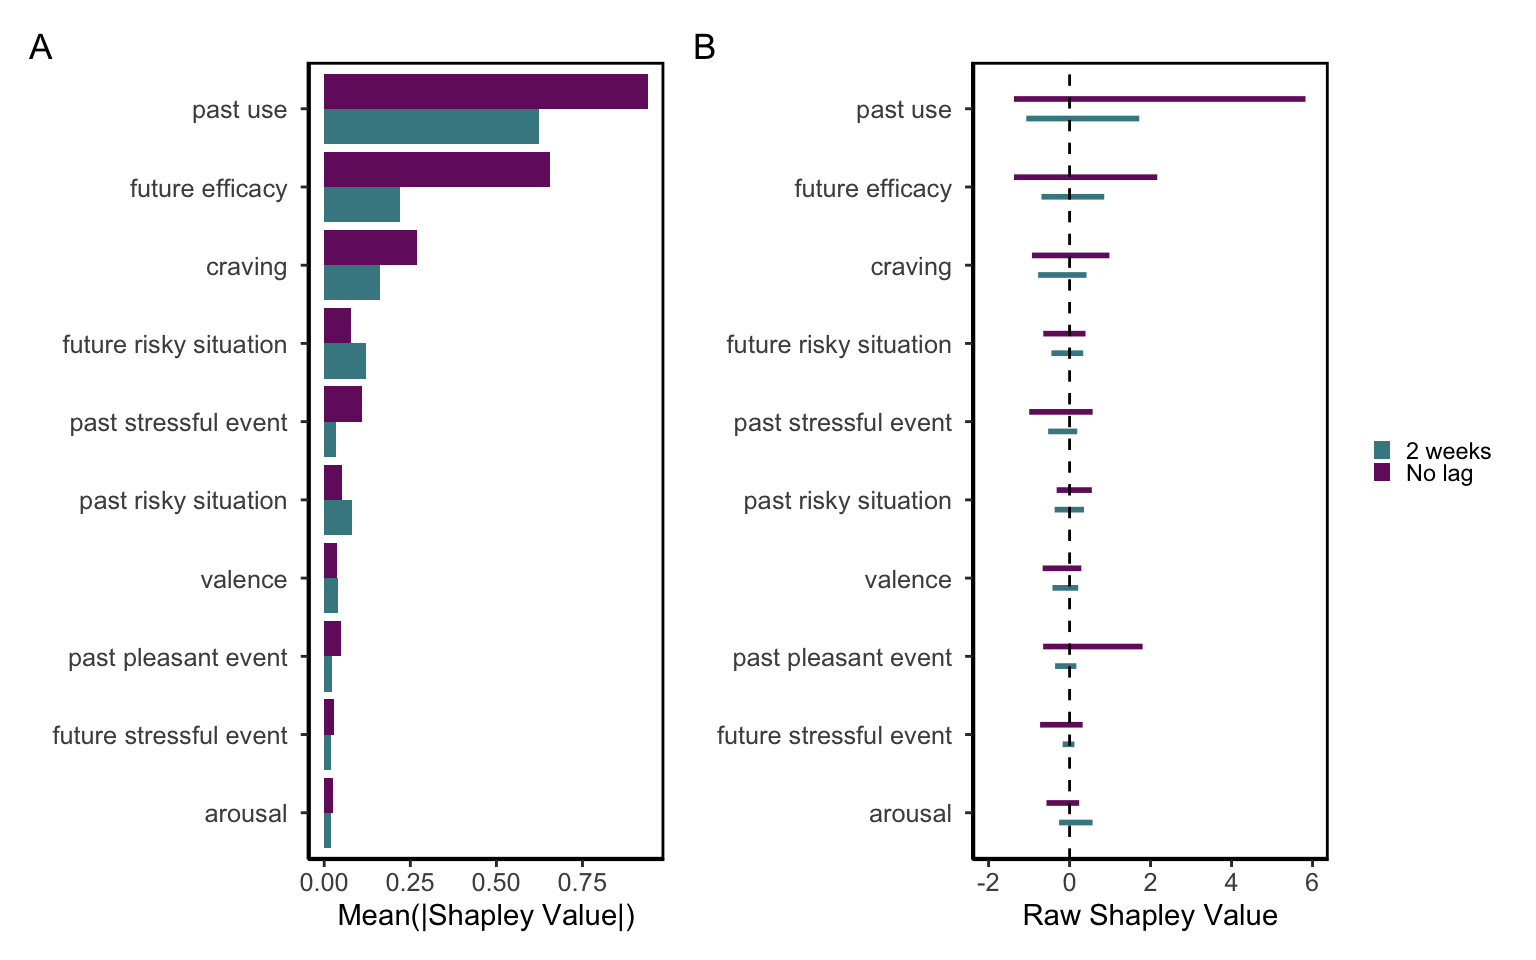

## Discussion

## Model Performance

Our models performed exceptionally well. Our no lag models had a .91 median posterior probability for auROC. This model predicts the probability of an immediate (i.e., within 24 hours) lapse back to alcohol use. Our 2-week lagged model, our most lagged model, had a .85 median posterior probability for auROC, suggesting lagged models can be used to shift a 24-hour prediction window up to weeks out.

Across all models (no lag, 1 day, 3 days, 1 week, and 2 weeks) we saw model performance decrease as models predicted further into the future. All lagged models had lower performance compared to the no lag baseline model and to the preceding adjacent lag model. This is unsurprising given what we know about prediction and substance use. Many important relapse risk factors are fluctuating processes that can change day-by-day, if not more frequently. As lag time increases, features become less proximal to the start of the prediction window. Still, we wish to emphasize that our lowest auROC (.85) is still quite good, and the benefit of advanced notice (i.e., 2 weeks) likely outweighs the cost to performance.

Collectively, these results suggest we can achieve clinically meaningful performance up to two weeks out. Our rigorous resampling methods (grouped, nested, k-fold cross-validation) make us confident that these are valid estimates of how our models would perform with new individuals.

When looking at global feature importance, or how important a feature category was to the model’s predictions, on average across all participants and all observations, the relative ordering of important features remained somewhat consistent across both our no lag and 2-week lag models. Past use, future efficacy, and craving were the top three features for both models. However the magnitude of their importance varied by lag time. For the 2-week lagged models, these top features were overall less important for the model’s predictions compared to the no lag model. This is consistent with the 2-week lagged model’s lower performance, compared to the no lag model.

When looking at local feature importance, or how important a feature category is for an individual prediction timepoint for a single individual on a specific day, we saw a wide variation in possible values for both the no lag and 2-week lag models. A wide range of possible values suggests that even feature categories with low global importance (e.g., past pleasant event) are important risk-relevant factors for some people on some days.

We believe our lapse prediction models will be most effective when embedded in a recovery monitoring and support system designed to deliver adaptive and personalized continuing care. This system could send daily, weekly, or less frequent messages to patients with personalized feedback about their risk of lapse and provide support recommendations tailored to their current recovery needs. This study provides initial support that immediate and lagged prediction models can be built with high accuracy using EMA for recovery monitoring. Furthermore, the high variance in importance of features for individual predictions is well suited for making tailored recovery support recommendations.

Our no lag models can be used to guide individuals to take immediate actionable steps to maintain their recovery goals and support them in implementing these steps (e.g., pointing them to a specific module in an app). For example, recommending an urge surfing activity when someone’s immediate risk is driven by strong craving, recommending a guided relaxation video when someone is reporting recent stressful events, or encouraging individuals to reflect on recent past successes or reasons for choosing abstinence or moderation when self-efficacy is low.

The 2-week lagged model provides individuals with advanced warning of their lapse risk. These models are well-suited to support recovery needs that cannot be addressed within an app, such as scheduling positive or pleasant activities, increasing social engagement, or attending a peer-led recovery meeting. To be clear, we do not believe an app alone is sufficient to deliver continuing care. We expect individuals will require additional support throughout their recovery from a mental health provider (e.g., motivational enhancement, crisis management, skill building), a peer (e.g., sponsor, support group), or family member. Importantly, these types of supports take time to set up; highlighting the value of this lagged week model.

## Model Fairness

In our previous study \[@wyantMachineLearningModels2023\], we failed to assess model fairness. In recent years, the machine learning field has begun to understand the critical importance of evaluating model fairness when algorithms are used to inform important decisions (e.g., healthcare services offered, eligibility for loans, early parole). Algorithms that perform favorably for only a single majority group could widen existing disparities in access to resources and important clinical outcomes \[@veinotGoodIntentionsAre2018\]. Therefore, we are committed to continuing to improve our understanding of and methods for evaluating model fairness. In this study, we assessed model fairness by comparing model performance across important subgroups with known disparities in substance use treatment access and/or outcomes - race/ethnicity (not White vs. non-Hispanic White), income (below poverty vs. above poverty), and sex at birth (female vs. male).

All models performed worse for people who were not White, and for people who had an income below the poverty line. The largest contributing factor is likely the lack of diversity in our training data. Our sample was majority non-Hispanic White (*N*=131, 87%) with an average income of \$34,000. As a result, even with our coarse combination of race/ethnicity, the not White group was severely underrepresented relative to the non-Hispanic White group. Similarly, although less severely, our below poverty group was underrepresented relative to the above poverty group.

One obvious potential solution to this problem is to recruit a more representative sample. These data were collected from 2015-2017. Our group has since committed to making changes in recruitment strategies. We are currently working to collect data from a more diverse sample of individuals with alcohol use disorder to improve these models \[@wyantOptimizingMessageComponentsinprep\]. In a separate project, we recruited a national sample of participants with opioid use disorder \[@moshontzProspectivePredictionLapses2021\]. In addition to achieving better representation in income and race/ethnicity, we also ensured diversity across geographic location (e.g., rural vs. urban) as this is likely another important factor in evaluating fairness.

Computational solutions to mitigate these issues in the current data may also exist. We could explore upsampling non-advantaged group representation in the data (e.g., using synthetic minority oversampling technique). We also could adjust the penalty weights so that prediction errors for non-advantaged groups are weighted more heavily than prediction errors for majority groups. We could also consider using personalized modeling approaches that consider the characteristics and behaviors important to an individual rather than generalizing across a population. For example, state space models can capitalize on time series data by building individual models for each participant using their own data. Individual models may help mitigate issues of unfairness, as the model will weigh the individual’s own data more heavily than group level estimates. In other words, how does lapse risk evolve over time for a specific individual.

The models also performed more poorly for women compared to men, despite the fact that they were well represented. This finding suggests representation in our data is not the only factor affecting model fairness. We chose our EMA items based on domain expertise and decades of relapse risk research. However, prior to 1993 National Institute of Health Revitalization Act \[@studiesNIHRevitalizationAct1994\] that mandated the inclusion of minorities and women in research, women were mostly excluded from most substance abuse treatment research due to their childbearing potential \[@vannicelliEffectSexBias1984\]. As a result, it is possible that these constructs more precisely describe relapse risk factors for men than for women. This could mean that more research is needed to identify relapse risk factors for women (e.g., interpersonal relationship problems \[@walitzerGenderDifferencesAlcohol2006a\], hormonal changes \[@mchughSexGenderDifferences2018a\]), and other groups underrepresented in the literature more broadly.

An alternative approach could be to use a data-driven (bottom-up) approach to identify patterns and characteristics predictive of lapse in specific groups. Compared to traditional, theory-driven (top-down) methods, data-driven features reduce potential bias in features by minimizing researcher involvement. For example, applying natural language processing to text message content could allow new categories of features to emerge. These categories may or may not align with existing theoretical concepts of lapse and relapse, but because they are generated from participants’ own words, they may serve as reliable indicators of lapse risk for certain individuals.

It is also true that historically marginalized groups that have experienced systemic racism, exclusion, or other stigma around substance use (e.g., societal expectations for women regarding attractiveness, cleanliness and motherhood \[@meyersIntersectionGenderDrug2021\]) may feel less trusting in disclosing substance use \[@marwickPrivacyMarginsUnderstanding2018\]. These experiences could result in individuals under-reporting lapses and/or risk factors, contributing to the gap in model performance. We saw a comparable, or slightly higher, percentage of positive lapse labels for disadvantaged compared to advantaged groups: race/ethnicity (6%, not White vs. 8%, non-Hispanic White), income (12%, below poverty vs. 7%, above poverty), sex at birth (9%, female vs. 7%, male). However, comparable lapse labels (i.e., reported lapses) does not necessarily equate comparable reporting (i.e., proportion of true lapses reported).<!--KW: I added a table of these results to supplement and now reference supplemental table in results.-->

## Additional Limitations and Future Directions

Despite building successful prediction models, it is still unclear the best way to provide risk and support information to people. For a recovery monitoring and support system to be successful, it is important that participants trust the system, engage with the system and find the system beneficial. In an ongoing grant, our group is working to optimize the delivery of daily support messages by examining whether the inclusion or exclusion of risk-relevant message components (e.g., lapse probability, lapse probability change, important features, and a risk-relevant recommendation) increase engagement in recovery tools and supports, trust in the machine learning model, and improve clinical outcomes \[@wyantOptimizingMessageComponentsinprep\].

For a system using lagged models, we can imagine that even longer lags (i.e., more advanced warning) would be better still. In the present study, we were limited by how much time we could lag predictions. Participants only provided EMA for up to three months. Therefore, a lag time of two weeks between the prediction time point and start of the prediction window means data from 2 out of the 12 possible weeks is not being used. This loss of data could be one reason we saw a decrease in model performance with increased lag times. In a separate NIH protocol underway, participants are providing EMA and other sensed data for up to 12 months \[@moshontzProspectivePredictionLapses2021\]. By comparing models built from these two datasets, we will better be able to evaluate whether this loss of data impacted model performance and if we can sustain similar performance with even longer lags in these data.

A recovery monitoring and support system will require new data to update model predictions. A model only using EMA could raise measurement burden concerns. Research suggests people can comply with effortful sensing methods (e.g., 4x daily EMA) while using substances \[@wyantAcceptabilityPersonalSensing2023; @jonesComplianceEcologicalMomentary2019\]. However, it is likely that frequent daily surveys will eventually become too burdensome when considering long-term monitoring. We have begun to address this by building models with fewer EMAs (1x daily) and have found comparable performance \[@pulickIdiographicLapsePredictionunderreview\]. Additionally, reinforcement learning could potentially be used for adaptive EMA sampling. For example, each day the algorithm could make a decision to send out an EMA or not based on inferred latent states of the individual based on previous EMA responses and predicted probability of lapse.

Additionally, we have begun to explore how we can supplement our models with data from other lower burden sensing methods. Geolocation is a passive sensing method that could compliment EMA well. First, it could provide insight into information not easily captured by self-report. For example, the amount of time spent in risky locations, or changes in routine that could indicate life stressors. Second, the near-continuous sampling of geolocation could offer risk-relevant information that would otherwise be missed in between the discrete sampling periods of EMA. Ultimately, passive sensing offers the opportunity to capture additional risk features that would be difficult to measure with self-report or would add additional burden by increasing the number of questions on the EMA.

## Conclusion

This study suggests it is possible to predict next day alcohol lapses up to two weeks into the future. This advanced notice could allow patients to implement support options not immediately available. Important steps are still needed to make these models clinically implementable. Most notably, is the increased fairness in model performance. However, we remain optimistic as we have already begun to take several steps in addressing these barriers.

## References